In [1]:
import pandas as pd
import numpy as np
df= pd.read_csv( r"C:\Users\User\Documents\GitHub\credit-risk-sentiment-nps\data\03_processed_data_ready_to_analyze.csv")

df.rename(columns={
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1": "NB_Attrition_Prob_Yes",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2": "NB_Attrition_Prob_No"
}, inplace=True)
df = df.drop(columns=['Last_Default_Date'])

C:\Users\User\AppData\Local\Temp\ipykernel_13168\2082154070.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


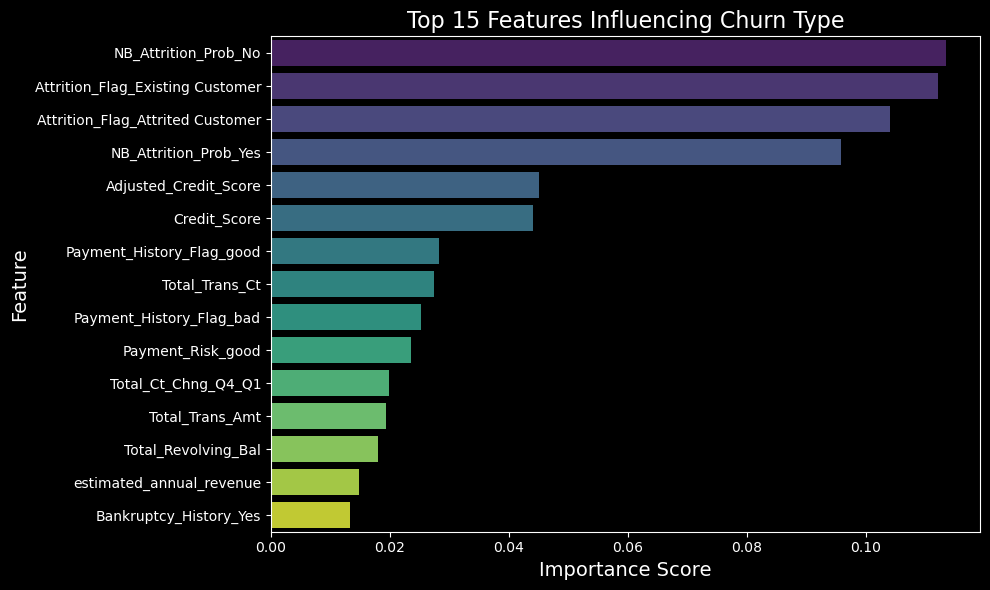

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# ==== 1. Prepare Data ====
# Assume 'Churn_Type' is the target column
X = df.drop(columns=['Churn_Type'])
y = df['Churn_Type']

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# ==== 2. Preprocessor ====
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ==== 3. Model ====
rf = RandomForestClassifier(random_state=42)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])

# ==== 4. Train-Test Split & Fit ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)

# ==== 5. Get Feature Importances ====
# Get feature names after preprocessing
ohe = clf.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

importances = clf.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# ==== 6. Plot 
plt.style.use('dark_background')

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 15 Features Influencing Churn Type', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


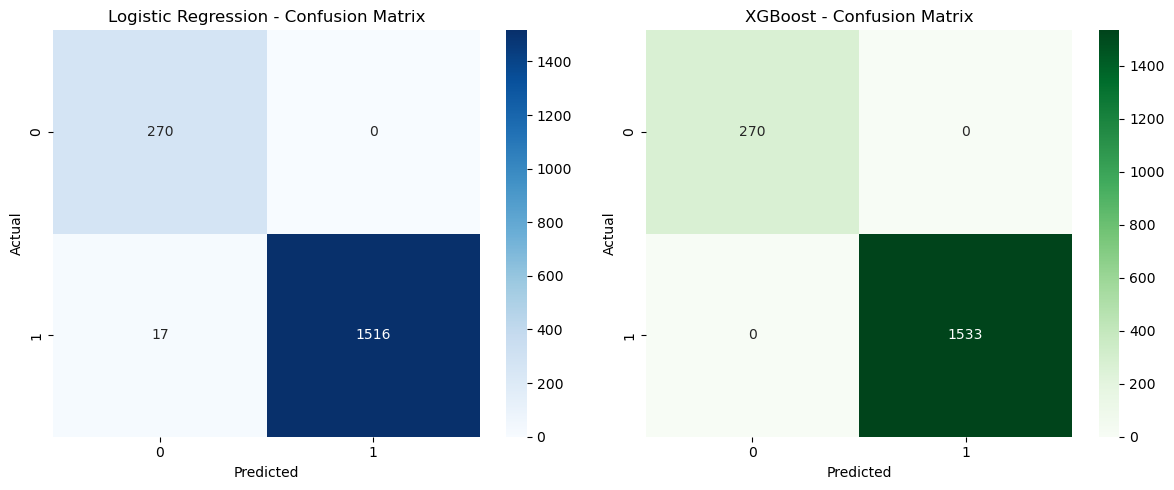

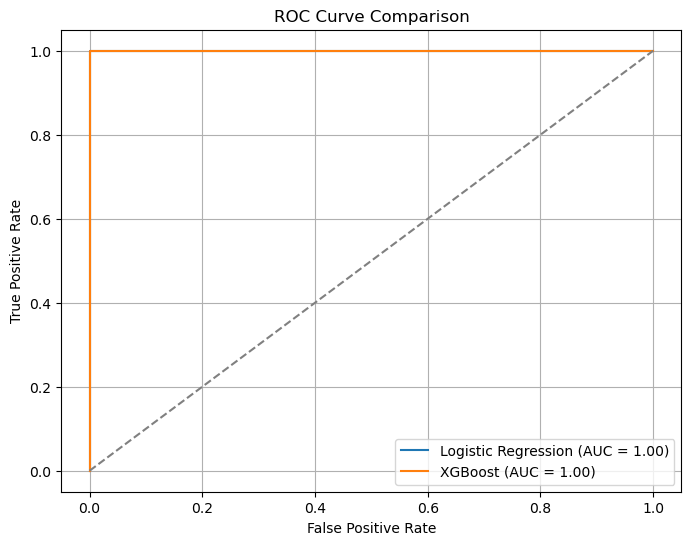

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb


target = 'Attrition_Flag'
X = df.drop(columns=[target])
y = df[target]

# Encode categorical target
le = LabelEncoder()
y = le.fit_transform(y)

# Scale numeric & one-hot encode categorical
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pd.get_dummies(X))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ===== 2. Logistic Regression =====
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

# ===== 3. XGBoost =====
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# ===== 4. Confusion Matrix =====
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression - Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("XGBoost - Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# ===== 5. ROC Curves =====
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc(fpr_lr, tpr_lr):.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc(fpr_xgb, tpr_xgb):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

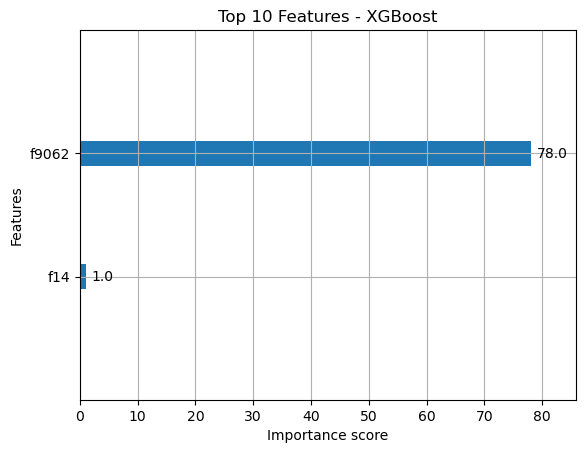

In [7]:
# ===== 6. XGBoost Feature Importance =====
plt.figure(figsize=(8, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("Top 10 Features - XGBoost")
plt.show()